# Modelling by Merchant Segment
## Forecasting Furniture Segment

In [1]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt


spark = (
    SparkSession.builder.appName("Furniture Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "16g")  # Increase driver memory
    .config("spark.executor.memory", "16g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/25 23:10:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read transaction file excluding those marked as fraud
transactions = spark.read.parquet('../data/curated/flagged_fraud')
transactions = transactions.filter(F.col("is_fraud") != True) # Exclude Fraud Transactions

## Filter Transactions by Segment (Furniture)

In [3]:
from pyspark.sql.functions import lower, col

furniture_transactions = transactions.filter(lower(col("merchant_category")).contains("furniture"))

furniture_transactions.show(truncate=False, n=10)

+------------+---------+-------+------------------+------------------------------------+-----------+--------------------------+----------------+------------------------------+--------------+-----------------+---------------+-------------+--------------------------+--------------+----------------+-------------+--------------------------------------+-----------------+---------------------------+---------------------------+--------+-------------------------------------------------------------------------------------+------------+-------------------+
|merchant_abn|year_week|user_id|dollar_value      |order_id                            |consumer_id|fraud_probability_consumer|name_consumer   |address_consumer              |state_consumer|postcode_consumer|gender_consumer|name_merchant|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011                         |unemployment_rate|consumer_weekly_transaction|merchant_weekly_transaction|is_fraud|merchant_categ

## Feature Engineering: Total Transaction Value (Yearly)
* Transactions within the furniture/home furnishing segments tend to be fewer in number but higher in value
* A high transaction volume could be a key indicator of a popular/favoured merchant

In [4]:
furniture_transactions = furniture_transactions.withColumn('order_year', F.year(F.col('order_datetime')))

yearly_transactions_df = furniture_transactions.groupBy('merchant_abn', 'order_year').agg(
    F.count("order_id").alias("total_transactions"),
    F.avg("dollar_value").alias("average_dollar_value"),
    F.avg("fraud_probability_merchant").alias("avg_fraud_probability_merchant"),
    F.avg("fraud_probability_consumer").alias("avg_fraud_probability_consumer"),
    F.avg("take_rate").alias("avg_take_rate"),
    F.avg("unemployment_rate").alias("avg_unemployment_cust"),
    F.first("name_merchant").alias("merchant_name"),
    F.first("merchant_category").alias("merchant_category"),
    F.first("revenue_band").alias("revenue_band") # Assuming revenue band is consistent for every merchant
)

In [5]:
# Create lag feature
window_spec = Window.partitionBy('merchant_abn').orderBy('order_year')
yearly_transactions_df = yearly_transactions_df.withColumn(
    'previous_year_transactions', F.lag('total_transactions', 1).over(window_spec)
).fillna(0)

In [6]:
yearly_transactions_df.show(truncate=False, n=10)

+------------+----------+------------------+--------------------+------------------------------+------------------------------+-------------------+---------------------+-------------------------------------+-------------------------------------------------------------------------------------+------------+--------------------------+
|merchant_abn|order_year|total_transactions|average_dollar_value|avg_fraud_probability_merchant|avg_fraud_probability_consumer|avg_take_rate      |avg_unemployment_cust|merchant_name                        |merchant_category                                                                    |revenue_band|previous_year_transactions|
+------------+----------+------------------+--------------------+------------------------------+------------------------------+-------------------+---------------------+-------------------------------------+-------------------------------------------------------------------------------------+------------+--------------------------

## Random Forest Regressor to Forecast Future Total Transactions

In [7]:
# Step 1: Feature Engineering
# Select relevant features for modeling
feature_columns = ['total_transactions', 'average_dollar_value', 'avg_fraud_probability_merchant', 
                   'avg_fraud_probability_consumer', 'avg_take_rate', 'avg_unemployment_cust', 'previous_year_transactions']

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Step 4: Random Forest Regressor Setup
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='total_transactions')

# Step 5: Create a Pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

In [8]:
# Step 6: Split Data into Training and Testing Sets
train_data, test_data = yearly_transactions_df.randomSplit([0.8, 0.2], seed=42)

# Step 7: Train the Random Forest Model
rf_model = pipeline.fit(train_data)

# Step 8: Evaluate Model on Test Data
predictions = rf_model.transform(test_data)

# Evaluate the model's performance using RMSE and R-squared
evaluator = RegressionEvaluator(labelCol="total_transactions", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Show some predictions alongside actual values
predictions.select("merchant_abn", "order_year", "total_transactions", "prediction").show(5)

Root Mean Squared Error (RMSE): 874.3556367186711
R-squared (R²): 0.6952342239084213


+------------+----------+------------------+------------------+
|merchant_abn|order_year|total_transactions|        prediction|
+------------+----------+------------------+------------------+
| 10323485998|      2021|              2406| 1267.025102684756|
| 10714068705|      2022|               503|425.10730096126815|
| 10860706939|      2022|                60| 156.9188357456349|
| 12103450178|      2021|                16| 71.69886437782507|
| 13447011295|      2022|               247|325.17868701412243|
+------------+----------+------------------+------------------+
only showing top 5 rows



In [9]:
# Step 1: Generate the future projection dataset
# Project future years based on the last available year for each merchant
future_total_transactions_df = yearly_transactions_df.groupBy('merchant_abn').agg(F.max('order_year').alias('latest_year'))

# Generate future year column
num_future_years = 1  # Number of future years to project
future_years = [(year,) for year in range(2023, 2023 + num_future_years)]  # Specify the future years you want to predict
future_years_df = spark.createDataFrame(future_years, ['order_year'])

# Cross-join merchants with future years
future_data = future_total_transactions_df.crossJoin(future_years_df)

# Step 2: Join the features from the latest available year for each merchant
latest_data = yearly_transactions_df.groupBy('merchant_abn').agg(
    F.max('order_year').alias('latest_year'),  # Get the latest available year for each merchant
    F.first('total_transactions').alias('total_transactions'),
    F.first('average_dollar_value').alias('average_dollar_value'),
    F.first('avg_fraud_probability_merchant').alias('avg_fraud_probability_merchant'),
    F.first('avg_fraud_probability_consumer').alias('avg_fraud_probability_consumer'),
    F.first('previous_year_transactions').alias('previous_year_transactions'),  # Corrected column name
    F.first('merchant_name').alias('merchant_name'),
    F.first("merchant_category").alias("merchant_category"),
    F.first('avg_take_rate').alias('avg_take_rate'),  # Corrected the take rate column name
    F.avg('avg_unemployment_cust').alias('avg_unemployment_cust')  # Assuming the correct unemployment column
)

# Join the latest available features with the future data
future_data = future_data.join(latest_data, on='merchant_abn', how='left')

# Step 3: Apply the trained model to predict the future repeat customer ratio
future_data = rf_model.transform(future_data)

# Step 4: Show predicted repeat customer ratio for future years
future_data.select('merchant_abn', 'order_year', 'prediction').show(10)

24/09/25 23:10:50 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------------+----------+------------------+
|merchant_abn|order_year|        prediction|
+------------+----------+------------------+
| 54702673300|      2023|  287.421732654479|
| 15700338102|      2023| 367.5268061695896|
| 35769589414|      2023|280.78438754966754|
| 35079621278|      2023| 21.15624188301333|
| 28836033916|      2023|35.600169340056006|
| 66741987958|      2023| 18.64065119274669|
| 46654841462|      2023|343.84373100176623|
| 10714068705|      2023|1665.9532517317311|
| 63937753588|      2023| 70.86990246449196|
| 14315147591|      2023|   160.21429364852|
+------------+----------+------------------+
only showing top 10 rows



In [10]:
future_predictions = future_data.withColumnRenamed('prediction', 'projected_total_orders')
future_predictions = future_predictions.orderBy(F.col('projected_total_orders').desc())

In [11]:
future_predictions = future_predictions.select('merchant_abn', 'order_year', 'total_transactions', 'average_dollar_value',
                                               'avg_fraud_probability_merchant', 'avg_fraud_probability_consumer', 'projected_total_orders','merchant_name','merchant_category')

In [12]:
future_predictions.show(truncate=False, n=10)

+------------+----------+------------------+--------------------+------------------------------+------------------------------+----------------------+------------------------------+--------------------------------------------------------------------------------------+
|merchant_abn|order_year|total_transactions|average_dollar_value|avg_fraud_probability_merchant|avg_fraud_probability_consumer|projected_total_orders|merchant_name                 |merchant_category                                                                     |
+------------+----------+------------------+--------------------+------------------------------+------------------------------+----------------------+------------------------------+--------------------------------------------------------------------------------------+
|38090089066 |2023      |36545             |163.2082987821643   |29.35533546356127             |12.894427168930058            |24275.723333333335    |Interdum Feugiat Sed Inc.     |furniture, h

# Export Ranking

In [13]:
future_predictions = future_predictions.select('merchant_abn', 'merchant_name', 'merchant_category', 'order_year', 'projected_total_orders')

In [14]:
#future_predictions.write.parquet('../data/curated/furniture_rankings')

## Model Evaluation

In [15]:
rf_stage = rf_model.stages[-1] 
importances = rf_stage.featureImportances
importance_values = importances.toArray()
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importance_values
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


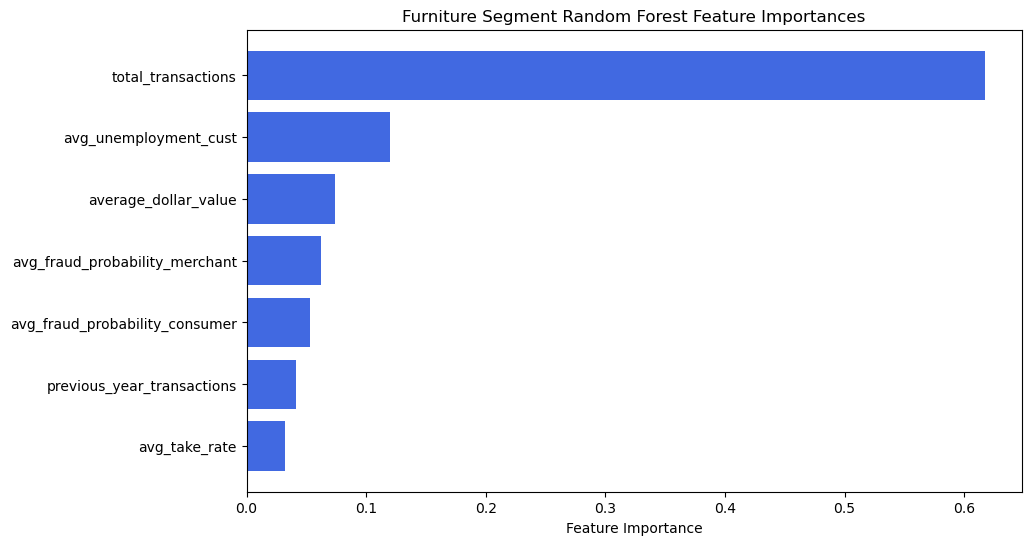

In [16]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Feature Importance')
plt.title('Furniture Segment Random Forest Feature Importances')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

In [17]:
spark.stop()